In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
Embedding_name="word2vec"
Dataset="ATE"


In [2]:
!pip show gensim

Name: gensim
Version: 3.8.1
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: /opt/conda/lib/python3.6/site-packages
Requires: smart-open, six, scipy, numpy
Required-by: 


In [3]:
!python --version

Python 3.6.6 :: Anaconda, Inc.


In [4]:
!pip --version

pip 19.3.1 from /opt/conda/lib/python3.6/site-packages/pip (python 3.6)


In [5]:
!pip show tensorflow
!pip show keras


Name: tensorflow
Version: 2.1.0rc0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.6/site-packages
Requires: termcolor, protobuf, keras-preprocessing, six, wrapt, absl-py, astor, gast, tensorboard, numpy, tensorflow-estimator, opt-einsum, keras-applications, wheel, google-pasta, grpcio
Required-by: fancyimpute
Name: Keras
Version: 2.3.1
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python3.6/site-packages
Requires: scipy, six, numpy, keras-preprocessing, keras-applications, h5py, pyyaml
Required-by: keras-tqdm, keras-rl, keras-resnet, keras-rcnn, fancyimpute, conx


In [6]:
import numpy as np
import json
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

!pip install git+https://www.github.com/keras-team/keras-contrib.git

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint,Callback
import matplotlib.pyplot as plt

!pip install fasttext

import fasttext
import fasttext.util

from sklearn.metrics import f1_score

from gensim.models import KeyedVectors
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        

Using TensorFlow backend.


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ae7d365i
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ae7d365i
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=e7b33370bbab8349f639ecf8650a96f6336fce351746517102575a8366dff575
  Stored in directory: /tmp/pip-ephem-wheel-cache-34fr0mw6/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
/kaggle/input/nernlp3/BiLSTM_word2vec.pkl
/kaggle/input/nernlp3/BiLSTM_fasttext.pkl
/kaggle/input/nernlp3/Assignment2/WordEmbeddings/glove.840B.300d.pkl
/kaggle/input/nernlp3/Assignment2/WordEmbeddings/Word2vec.bin
/kaggle/input/nernlp3/Assignment2/WordEmbeddings/cc.en.300.bin
/kaggle/input/nernlp3/Assignment2/Data/check.py
/kaggle/input/nernlp3/Assignment2/Data/NER_TRAIN_JUDGEMENT.json
/kaggle/input/nernlp3/Assignment2/Data/Laptop_Review_Val.json
/kaggle/input/nernl

In [7]:
!pip show git+https://www.github.com/keras-team/keras-contrib.git

In [8]:
PATH = "/kaggle/input/nernlp3/Assignment2/"
OUTPATH = "/kaggle/working/"
# Any results you write to the current directory are saved as output.

In [9]:
! mkdir Saved_Models
! mkdir Saved_Models/ATE
! mkdir Saved_Models/NER
! mkdir Graphs

In [10]:
def checking(a):
    print("Hello World",a)

def new_checking(a):
    print("Hello World",a)

def create_train_test_val(file):
    lst_out_text=[]
    lst_out_labels=[]
    for i in file.values():
        sentence = i['text']
        sentence = sentence.lower()
        labels = i['labels']
        lst_out_text.append(sentence)
        lst_out_labels.append(labels)
    return lst_out_text,lst_out_labels    

def TokenCreator(sentences,val,tokenizer=None):
    
    temp_wordlist = None
    tokenizer2=None
    if(tokenizer == None):
        if val==1:
            tokenizer2 = Tokenizer(oov_token="#UK",filters='')
        else:
            tokenizer2=Tokenizer()
        tokenizer2.fit_on_texts(sentences)
        
        temp_wordlist = tokenizer2.texts_to_sequences(sentences)
        return (temp_wordlist,tokenizer2)
    
    else:
        temp_wordlist = tokenizer.texts_to_sequences(sentences)
        return temp_wordlist
    
def find_vocab(dataset):
    lst=[]
    lst.append("#UK")
    for i in dataset:
        for j in i:
            lst.append(j)
    st = set(lst)
    return st

'''
--------------------------------------GRAPHS--------------------------------------
'''

def draw_loss_graph(model,model_name,f1_scores_train,f1_scores_val):
    train_loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = [i+1 for i in range(len(train_loss))]
    train_y = train_loss
    val_y = val_loss
    
    fig, axes = plt.subplots(1,2,figsize = (16,5))
    # plt.subplots(axes = (2,1))
    axes[0].plot(x,train_y, color = 'blue')  
    
    axes[0].plot(x,val_y, color = 'red') 
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(x,f1_scores_train, color = 'blue')
    axes[1].plot(x,f1_scores_val, color = 'red')
    axes[1].set_title('F1 Score vs Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')

    axes[0].legend(['Train','Val'])
    axes[1].legend(['Train','Val'])
    
    plt.suptitle(model_name)

    plt.savefig(f'{OUTPATH}Graphs/{model_name}.png')    
    plt.show()
    

In [11]:
'''
--------------------------------------MODELS--------------------------------------
'''

def save_model(model,model_name, embedding, dataset):
    with open(f'{OUTPATH}Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'wb') as file:
        pickle.dump(model, file)

def load_model(model_name, embedding, dataset):
    with open(f'{OUTPATH}Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    
    return loaded_model


In [12]:
'''
--------------------------------------CALLBACKS--------------------------------------
'''

class F1ScoreCallback(Callback):

    def __init__(self, val_data, data):
        super(F1ScoreCallback, self).__init__()
        self.val_data = val_data
        self.data=data
        self.val_f1_scores = [] 
        self.train_f1_scores = []

    

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.val_data
        x_data, y_data = self.data
        y_pred_val = self.model.predict(x_val)
        y_pred_train = self.model.predict(x_data)

        def scikitf1(pred,real):

            true_labels_flat = [label for sublist in real for label in sublist]
            predicted_labels_flat = [label for sublist in pred for label in sublist]
            # Compute F1 score
            f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
            return f1
        def get_pred(Y_padded_output):
                # print(Y_padded_output.shape)
                final_output=[]
                for i in range(Y_padded_output.shape[0]):
                    output=[]
                    for j in range(Y_padded_output.shape[1]):
                        max_value=-1
                        maxIndex=-1
                        for k in range(Y_padded_output.shape[2]):
                            if Y_padded_output[i][j][k]>max_value:
                                maxIndex=k
                                max_value=max(max_value,Y_padded_output[i][j][k])
                        output.append(maxIndex)
                    final_output.append(output)
                return final_output

        def get_real(Y_padded_test):
            # print(Y_padded_test.shape)
            final_Y=[]
            for i in range(Y_padded_test.shape[0]):
                output=[]
                for j in range(Y_padded_test.shape[1]):
                    max_value=-1
                    maxIndex=-1
                    for k in range(Y_padded_test.shape[2]):
                        if Y_padded_test[i][j][k]>max_value:
                            maxIndex=k
                            max_value=max(max_value,Y_padded_test[i][j][k])
                    output.append(maxIndex)
                final_Y.append(output)
            return final_Y
        
        # print("here")
        pred_train=get_pred(y_pred_train)
        # print(pred_train)
        real_train=get_real(y_data)
        # print(real_train)

        pred_val=get_pred(y_pred_val)
        real_val=get_real(y_val)

        f1_train = scikitf1(pred_train,real_train)
        f1_val = scikitf1(pred_val,real_val)

        self.val_f1_scores.append(f1_val)
        self.train_f1_scores.append(f1_train)
        print(f'Val F1 Score: {f1_val} - Train F1 Score: {f1_train}')



#---------Prediction Functions----------------------------------------------
def get_pred(Y_padded_output):
    final_output=[]
    for i in range(Y_padded_output.shape[0]):
        output=[]
        for j in range(Y_padded_output.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_output.shape[2]):
                if Y_padded_output[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_output[i][j][k])
            output.append(maxIndex)
        final_output.append(output)
    return final_output

def get_real(Y_padded_test):
    final_Y=[]
    for i in range(Y_padded_test.shape[0]):
        output=[]
        for j in range(Y_padded_test.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_test.shape[2]):
                if Y_padded_test[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_test[i][j][k])
            output.append(maxIndex)
        final_Y.append(output)
    return final_Y

def my_f1(y_true, y_pred):
    
    # predictions = get_pred(y_pred)
    # real = get_real(y_true)

    predictions = y_pred
    real = y_true

    size=len(predictions)

    unique_labels= set()

    for labels in real:
        unique_labels.update(labels)

    for labels in predictions:
        unique_labels.update(labels)

    labels_f1=[]

    for labels in unique_labels:
        tp=0
        fp=0
        fn=0

        for i in range(size):
                    
            tp+=sum((p==labels and r==labels) for p,r in zip(predictions[i],real[i]))
            fp+=sum((p==labels and r!=labels) for p,r in zip(predictions[i],real[i]))
            fn+=sum((p!=labels and r==labels) for p,r in zip(predictions[i],real[i]))

        
        precision = tp/(tp+fp) if tp+fp>0 else 0
        recall = tp/(tp+fn) if tp+fn>0 else 0

        f1=2*((precision*recall)/(precision+recall)) if precision+recall>0 else 0

        labels_f1.append(f1)
        print(f1,unique_labels)
    macro_f1 = sum(labels_f1)/len(unique_labels)
    return macro_f1

def scikitf1(pred,real):

    true_labels_flat = [label for sublist in real for label in sublist]
    predicted_labels_flat = [label for sublist in pred for label in sublist]
    # Compute F1 score
    f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
    return f1

In [13]:
seed_value = 18
np.random.seed(seed_value)


In [14]:
if Embedding_name=="word2vec":
    emb = KeyedVectors.load_word2vec_format(f'{PATH}WordEmbeddings/Word2vec.bin',binary=True)

if Embedding_name=="glove":
    with open(f'{PATH}WordEmbeddings/glove.840B.300d.pkl', 'rb') as fp:
        emb = pickle.load(fp)

if Embedding_name=="fasttext":
    emb = fasttext.load_model(f'{PATH}WordEmbeddings/cc.en.300.bin')

# Preproc

In [15]:



train = None
test = None
val = None
with open(f"{PATH}Data/processed/{Dataset}_train.json") as f1:
    train = json.load(f1)

with open(f"{PATH}Data/processed/{Dataset}_test.json") as f2:
    test = json.load(f2)

with open(f"{PATH}Data/processed/{Dataset}_val.json") as f3:
    val = json.load(f3)



In [16]:
X_train,Y_train = create_train_test_val(train)
X_test,Y_test = create_train_test_val(test)
X_val,Y_val = create_train_test_val(val)

In [17]:
from keras.preprocessing.text import *

X_train_tokenized, toke = TokenCreator(X_train,1)
X_test_tokenized = TokenCreator(X_test,0,tokenizer = toke)
X_val_tokenized = TokenCreator(X_val,0,tokenizer = toke)

Y_train_tokenized,toke2 = TokenCreator(Y_train,0)
Y_test_tokenized = TokenCreator(Y_test,0,tokenizer = toke2)
Y_val_tokenized = TokenCreator(Y_val,0,tokenizer = toke2)

st1 = find_vocab(X_train_tokenized)
vocab_size  = len(st1) + 1 

max_len=0

for i in X_train_tokenized:
    max_len = max(max_len,len(i))

X_padded_train = pad_sequences(X_train_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_tokenized, maxlen=max_len, padding="pre", truncating="post")  

Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

weights = np.zeros((vocab_size, 300))
mapping = toke.word_index 

for word, index in mapping.items():
    if word in emb:
        weights[index:] = emb[word]

In [18]:
X_train= X_padded_train
Y_train = Y_padded_train
X_test = X_padded_test
Y_test = Y_padded_test
X_val = X_padded_val
Y_val = Y_padded_val
weights = weights
word_token = toke
tag_token = toke2
Y_shape= Y_padded_train.shape[2]

# Bilstm+crf

In [19]:
def BiLSTM(weights,vocab_size,max_len,Y_shape):
    input = Input(shape=(max_len,))
    model = Embedding(vocab_size, 300, weights=[weights], input_length=max_len, trainable=False)(input)
    model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5,dropout=0.07,kernel_initializer=k.initializers.he_normal()))(model)
    model = TimeDistributed(Dense(Y_shape, activation="relu"))(model)  # softmax output layer
    crf = CRF(Y_shape)  # CRF layer
    out = crf(model)  # output
    model = Model(input, out)
    adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
    return model

In [20]:
model_name="BiLSTM"

n_words=vocab_size
n_tags=Y_train.shape[2]
input = Input(shape=(max_len,))
word_embedding_size = 300

model = BiLSTM(weights,n_words,max_len,n_tags)
model.summary()


/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 78)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 78, 300)           721800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 78, 512)           1140736   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 78, 4)             2052      
_________________________________________________________________
crf_1 (CRF)                  (None, 78, 4)             44        
Total params: 1,864,632
Trainable params: 1,142,832
Non-trainable params: 721,800
_________________________________________________________________


In [21]:
BiLSTM_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))
callbacks_list = [BiLSTM_f1_callback]
# Fit the best model
history = model.fit(X_train, Y_train, batch_size=256, epochs=20, validation_data=(X_val,Y_val), verbose=1, callbacks=callbacks_list)



Train on 906 samples, validate on 219 samples
Epoch 1/20
906/906 [==============================] - 12s 13ms/step - loss: 0.8461 - crf_viterbi_accuracy: 0.6593 - accuracy: 0.7544 - val_loss: 0.2854 - val_crf_viterbi_accuracy: 0.9529 - val_accuracy: 0.9529
Val F1 Score: 0.4787853232373563 - Train F1 Score: 0.476343236068117
Epoch 2/20
906/906 [==============================] - 7s 8ms/step - loss: 0.2252 - crf_viterbi_accuracy: 0.9484 - accuracy: 0.7544 - val_loss: 0.1191 - val_crf_viterbi_accuracy: 0.9683 - val_accuracy: 0.9683


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val F1 Score: 0.48716626114617717 - Train F1 Score: 0.4808201459570549
Epoch 3/20
906/906 [==============================] - 7s 8ms/step - loss: 0.1116 - crf_viterbi_accuracy: 0.9704 - accuracy: 0.7544 - val_loss: 0.0866 - val_crf_viterbi_accuracy: 0.9745 - val_accuracy: 0.9745
Val F1 Score: 0.4862737637951272 - Train F1 Score: 0.48561073606499894
Epoch 4/20
906/906 [==============================] - 7s 8ms/step - loss: 0.0874 - crf_viterbi_accuracy: 0.9730 - accuracy: 0.7544 - val_loss: 0.0776 - val_crf_viterbi_accuracy: 0.9747 - val_accuracy: 0.9747
Val F1 Score: 0.4863826072732315 - Train F1 Score: 0.48572108530420915
Epoch 5/20
906/906 [==============================] - 7s 8ms/step - loss: 0.0779 - crf_viterbi_accuracy: 0.9732 - accuracy: 0.7544 - val_loss: 0.0688 - val_crf_viterbi_accuracy: 0.9749 - val_accuracy: 0.9749
Val F1 Score: 0.5192528538854385 - Train F1 Score: 0.5093713031503068
Epoch 6/20
906/906 [==============================] - 7s 8ms/step - loss: 0.0699 - crf_viterb

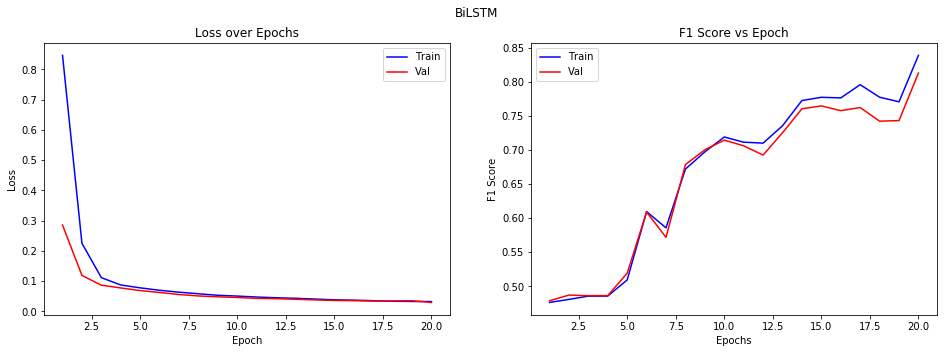

In [22]:
draw_loss_graph(history,model_name, BiLSTM_f1_callback.train_f1_scores, BiLSTM_f1_callback.val_f1_scores)

In [23]:
save_model(model.get_weights(),model_name,Embedding_name,Dataset)

In [24]:
model.save("model75")

In [25]:
loaded_params=load_model(model_name,Embedding_name,Dataset)
loaded_model=BiLSTM(weights,n_words,max_len,n_tags)
loaded_model.set_weights(loaded_params)

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


# Testing

In [26]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print("Accuracy:", accuracy[1])

Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

328/328 [==============================] - 2s 6ms/step
Accuracy: 0.9816797375679016
Test F1 Score: 0.7845944700367797
